<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/4.House/House_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.EDA

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [159]:
from google.colab import drive
drive.mount('/content/gdrive')
train_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/house_train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/house_test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [160]:
df=pd.concat([train_df,test_df],axis=0,ignore_index=True)

##1) Basic statistics

In [161]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [162]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

##2) Basic feature selection


In [163]:
df.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu','Id'],axis=1,inplace=True) #features with too little data(logical thinking) #Surprisingly all data were meaningful by own meaning

#2.Preprocessing

In [164]:
discrete=[var for var in df.columns if df[var].dtype!='object' and var!='SalePrice' and df[var].nunique()<10] 
continuous=[var for var in df.columns if df[var].dtype!='object' and var!='SalePrice' and var not in discrete]
categorical=[var for var in df.columns if df[var].dtype=='object'] 
print(f'discrete:{discrete}\ncontinuous:{continuous}\ncategorical:{categorical}')

discrete:['OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'YrSold']
continuous:['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']
categorical:['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', '

##1) Imputation

In [165]:
df.isnull().sum().sort_values(ascending=False).head(35)

SalePrice       1459
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
BsmtFinSF1         1
BsmtFinSF2         1
Exterior2nd        1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
Electrical         1
Exterior1st        1
KitchenQual        1
SaleType           1
GarageCars         1
LotShape           0
Street             0
LotArea            0
LandContour        0
Neighborhood       0
dtype: int64

In [166]:
from sklearn.impute import SimpleImputer
random=['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1','MasVnrType','MasVnrArea','MSZoning','Utilities','Functional','BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','Exterior2nd','GarageArea','TotalBsmtSF','BsmtUnfSF','Electrical','Exterior1st','KitchenQual','SaleType','GarageCars']
imputer=SimpleImputer(strategy='most_frequent')
df[random]=imputer.fit_transform(df[random])
df.isnull().sum().sort_values(ascending=False).head(10) 

SalePrice       1459
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
MasVnrType         0
RoofStyle          0
RoofMatl           0
dtype: int64

##2) Encoding
Further imputation needs encoding

In [167]:
for var in categorical:
  print(var,':',df[var].nunique())

MSZoning : 5
Street : 2
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 4
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 4
BsmtCond : 4
BsmtExposure : 4
BsmtFinType1 : 6
BsmtFinType2 : 6
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 5
KitchenQual : 4
Functional : 7
GarageType : 6
GarageFinish : 3
GarageQual : 5
GarageCond : 5
PavedDrive : 3
SaleType : 9
SaleCondition : 6


In [168]:
garage=df[['GarageCars','GarageArea','GarageYrBlt','GarageFinish','GarageQual','GarageCond','GarageType']]#5 out of 6 missing data were related to garage(7garagecolumns)
lot=df[['LotFrontage','LotArea','LotShape','LotConfig']]

In [169]:
df.groupby('LotShape')['LotFrontage'].median()

LotShape
IR1    74.0
IR2    57.0
IR3    90.0
Reg    65.0
Name: LotFrontage, dtype: float64

In [170]:
df.groupby('LotConfig')['LotFrontage'].median()

LotConfig
Corner     80.0
CulDSac    50.0
FR2        62.0
FR3        66.0
Inside     66.0
Name: LotFrontage, dtype: float64

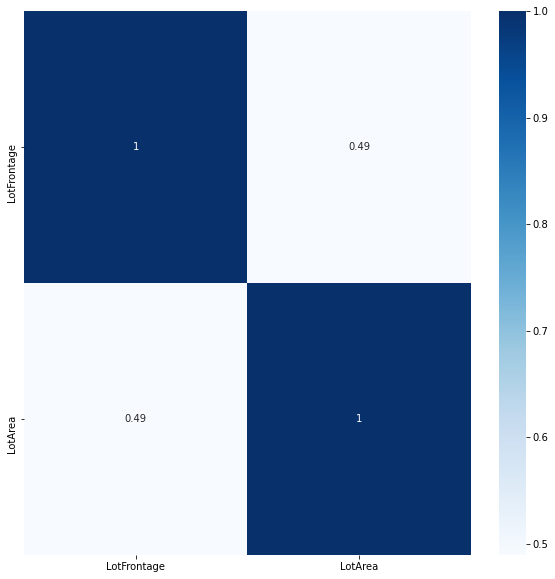

In [171]:
fig=plt.figure(figsize=(10,10))
sns.heatmap(lot.corr(),cmap='Blues',annot=True)

##3) Discretization&Scaling

In [174]:
for var in continuous:
  print(var,':',df[var].nunique())

MSSubClass : 16
LotFrontage : 128
LotArea : 1951
OverallQual : 10
YearBuilt : 118
YearRemodAdd : 61
MasVnrArea : 444
BsmtFinSF1 : 991
BsmtFinSF2 : 272
BsmtUnfSF : 1135
TotalBsmtSF : 1058
1stFlrSF : 1083
2ndFlrSF : 635
LowQualFinSF : 36
GrLivArea : 1292
TotRmsAbvGrd : 14
GarageYrBlt : 103
GarageArea : 603
WoodDeckSF : 379
OpenPorchSF : 252
EnclosedPorch : 183
3SsnPorch : 31
ScreenPorch : 121
PoolArea : 14
MiscVal : 38
MoSold : 12


##4) feature selection

#3.Modeling

In [ ]:
test_df=df[df['SalePrice'].isna()!=0]
train_df=df[df['SalePrice'].isna()==0]
target_df=train_df['SalePrice']
feature_df=train_df.drop(['SalePrice'],axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(feature_df,target_df,test_size=0.2,random_state=42)

In [ ]:
def get_eval(real,pred):
  eval=np.sqrt(mean_squred_error(np.log1p(real),pred)) #mse is embedded metric #only targetdata is logscaled 
  print('RMSLE:',eval)

In [ ]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred1=lr_reg.predict(X_test)
ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
pred2=ridge_reg.predict(X_test)
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)
pred3=lasso_reg.predict(X_test)

In [ ]:
get_eval(y_test,pred1)
get_eval(y_test,pred2)
get_eval(y_test,pred3)

#Uploading

#1) Feedback

#2) Afterwords
